# Neural Trojan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle

from helpers import load_data_from_pickle

## Internal Neuron Selection
According to the paper "Trojan Attack on Neural Networks", choosing the last internal layer leads to poor performance, so the layer to choose the neuron(s) to attack is easy:
We will attack the first (out of two) dense layers, which has 500 neurons.

In [2]:
# Load pre-trained model
model_path = 'model-3x3.keras'
model = load_model(model_path)

In [3]:
for layer in model.layers:
    print(layer.name, layer.__class__.__name__)

conv2d_2 Conv2D
max_pooling2d_2 MaxPooling2D
flatten_2 Flatten
dense_4 Dense
dense_5 Dense


In [4]:
# Retrieve weights between the first and second dense layer
layer_to_attack = 'dense_4'
first_dense_layer = model.get_layer(layer_to_attack)
weights, biases = first_dense_layer.get_weights()

number_of_neurons_to_attack = 5

neuron_influence = np.sum(np.abs(weights), axis=1)
most_influential_neurons = np.argsort(neuron_influence)[::-1][:number_of_neurons_to_attack]

print("Most influential neurons:", most_influential_neurons)

Most influential neurons: [4320 4328 4352 4363 4347]


## Neural Trigger Generation

### Trigger Mask

In [5]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_from_pickle()

In [13]:
y_test[0]

25

In [6]:
image_shape = x_train[0].shape
print(f"{image_shape=}")

image_shape=(32, 32, 3)


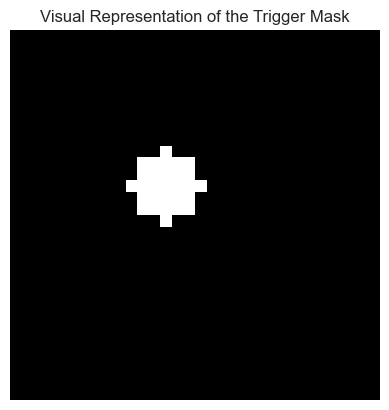

In [7]:
# Define mask properties
mask_size = 7  # Size of the mask (5x5 pixels)
mask_shape = 'circle'  # Shape of the mask, could be 'circle' or 'square'
mask_location = (10, 10)  # Starting location of the top-left corner of the mask within the image

# Create an empty mask of zeros with the same shape as the image
mask = np.zeros(image_shape[:2], dtype=np.float32)  # Only 2D needed for the mask

# Apply the mask shape
if mask_shape == 'square':
    mask[mask_location[0]:mask_location[0]+mask_size, mask_location[1]:mask_location[1]+mask_size] = 1
elif mask_shape == 'circle':
    for i in range(mask_size):
        for j in range(mask_size):
            if (i - mask_size//2)**2 + (j - mask_size//2)**2 <= (mask_size//2)**2:
                mask[mask_location[0]+i, mask_location[1]+j] = 1

# Expand mask dimensions to fit the color channels if necessary
mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

# Plotting the mask
plt.imshow(mask, cmap='gray')
plt.title('Visual Representation of the Trigger Mask')
plt.axis('off')
plt.show()

### Trigger Generation

In [11]:
# file_path = 'average_images/avg_image_train.pkl'
file_path = 'average_images/random_image.pkl'
with open(file_path, 'rb') as file:
    base_image = pickle.load(file)

print("Loaded image shape:", base_image.shape)

Loaded image shape: (32, 32, 3)


In [12]:
layer_output = model.get_layer(layer_to_attack).output
loss = tf.reduce_sum(layer_output[:, most_influential_neurons])
input_img_data = base_image
input_img_data = (input_img_data - 0.5) * 20 + 128  # Scale the random noise
"""
# Gradient ascent
for _ in range(iterations):
    with tf.GradientTape() as tape:
        tape.watch(input_img_data)
        loss_value = loss(input_img_data, training=False)
    grads = tape.gradient(loss_value, input_img_data)
    grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)  # Normalize for better performance
    input_img_data += grads * step_size  # Modify the image to maximize the neuron activation

optimized_trigger = input_img_data.numpy()
"""

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Loaded image shape: (32, 32, 3)


In [30]:
model.input

ValueError: The layer sequential_2 has never been called and thus has no defined input.

In [38]:
from tensorflow.keras.models import Model

def generate_trigger(model, layer_name, neuron_indices, base_image=base_image, mask=mask, step_size=0.1, epochs=10):
    input_img = tf.Variable(base_image, dtype=tf.float32)

    # Create an intermediate model to get outputs from the specified layer
    layer_output = model.get_layer(layer_name).output
    intermediate_model = Model(inputs=model.input, outputs=layer_output)

    for _ in range(epochs):
        with tf.GradientTape() as tape:
            tape.watch(input_img)
            # Use intermediate model to get output from the specified layer
            output = intermediate_model(input_img[tf.newaxis, ...])
            neuron_activations = tf.gather(output, indices=neuron_indices, axis=1)
            loss = -tf.reduce_sum(neuron_activations)

        grads = tape.gradient(loss, input_img)
        modified_grads = grads * mask
        input_img.assign_add(modified_grads * step_size)

    return input_img.numpy()

In [43]:
model.inputs[0].shape

(None, 32, 32, 3)

In [82]:
tf.constant(most_influential_neurons, dtype=tf.int32)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([4320, 4328, 4352, 4363, 4347, 4800, 4838, 3816, 3808, 4358])>

In [39]:
input_img = generate_trigger(model=model,
                             layer_name=layer_to_attack,
                             neuron_indices=most_influential_neurons)

AttributeError: 'tuple' object has no attribute 'dims'